# Network analysis on the IMDB database

In [305]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import json
import datetime
import itertools
import community

Read in the cleaned datasets. Mod is all modern movies (post 1960) with ratings so that we can filter for more "popular" movies.

In [306]:
mod = pd.read_csv("ModernMovieswRatings.csv")

Only use movies with more than 4171 votes (the mean) and an overall rating above 1. This reduces the number of movies to 12,362.

In [307]:
mod2 = mod.loc[mod['numVotes'] >= 4171]
mod2 = mod2.loc[mod2['averageRating'] > 1]

In [5]:
mod2['tconst'].nunique()

12362

Create a df of all the names with their unique identifieds (nconst). There are 50,183 total people.

In [6]:
names = pd.DataFrame(mod2[['nconst','primaryName']].drop_duplicates())
names.count()

nconst         50183
primaryName    50182
dtype: int64

Create list of all movies to loop through to create dyadic dataset.

In [7]:
movies = mod2['tconst'].unique().tolist()

Loop through all 12,362 movies and create dyads for each pair of people listed as principals in the same movie.

In [19]:
df = pd.DataFrame()
counter = 0
for x in movies:
    counter = counter + 1
    movie = mod2.loc[mod2['tconst'] == x]
    temp = pd.DataFrame(list(itertools.combinations(movie['nconst'], 2)))
    if len(temp) == 0:
        continue
    temp.columns= ['source', 'target']
    df = pd.concat([df,temp])
    if counter%1000 == 0:
        print(x + " " + str( counter) + " " + str(datetime.datetime.now()))
df = df.groupby(["source", "target"]).size().reset_index(name="freq")

tt0077696 1000 2019-08-03 10:25:44.080337
tt0094663 2000 2019-08-03 10:25:55.377090
tt0109842 3000 2019-08-03 10:26:09.383442
tt0126916 4000 2019-08-03 10:26:25.786791
tt0278291 5000 2019-08-03 10:26:45.020427
tt0389828 6000 2019-08-03 10:27:07.748162
tt0499375 7000 2019-08-03 10:27:35.002858
tt1172203 8000 2019-08-03 10:28:05.096541
tt1598873 9000 2019-08-03 10:28:38.322480
tt2165765 10000 2019-08-03 10:29:14.365905
tt3411444 11000 2019-08-03 10:29:53.182000
tt6010628 12000 2019-08-03 10:30:33.100304


In [46]:
df1 = pd.merge(df,names,how='left',left_on='source',right_on='nconst')
df1 = pd.merge(df1,names,how='left',left_on='target',right_on='nconst')
df1 = df1[['primaryName_x','primaryName_y','freq']]
df1.columns= ['source', 'target','freq']

In [47]:
df1.to_csv("cleanNetwork.csv")

In [327]:
df1 = pd.read_csv("cleanNetwork.csv")
df1 = df1[['source','target','freq']]

In [328]:
df1 = df1.dropna()

There are a total of 546,391 connections, 512,643 of which are unique.

In [329]:
print(str(df1['freq'].sum()) + " total connections")
print(str(df1['freq'].count()) + " unique connections")

546391 total connections
512643 unique connections


Who made the most movies in 2018? Miles Long. He made 41 movies with 265 unique collaborators.

In [330]:
pd.set_option('mode.chained_assignment', None)
mod2018 = mod.loc[mod['startYear'] == 2018]
mod2018['freq'] = mod2018.groupby('primaryName')['primaryName'].transform('count')
mod2018.groupby('primaryName')['freq'].count().sort_values(ascending=False).head()

primaryName
Miles Long             41
Kevin MacLeod          27
Gopi Sundar            20
William Shakespeare    19
Evan Tramel            18
Name: freq, dtype: int64

In [331]:
miles = getNetwork("nm0519117",mod)
miles = miles.drop_duplicates()
miles.count()

nconst_y    265
Name        265
dtype: int64

In [332]:
mod2018.loc[mod2018['primaryName'] == "Miles Long"]["primaryProfession"].head(1)

2579809    cinematographer,director,camera_department
Name: primaryProfession, dtype: object

List of people who made the most movies.

In [333]:
pd.set_option('mode.chained_assignment', None)
mod2['freq'] = mod2.groupby('primaryName')['primaryName'].transform('count')
mod2.groupby('primaryName')['freq'].count().sort_values(ascending=False).head()

primaryName
Jerry Goldsmith        82
Robert De Niro         82
Nicolas Cage           73
Scott Rudin            71
James Newton Howard    69
Name: freq, dtype: int64

In [334]:
mod2.loc[mod2['primaryName'] == "Miles Long"]

,Unnamed: 0,tconst,ordering,nconst,category,job,characters,titleType,primaryTitle,originalTitle,...,runtimeMinutes,genres,averageRating,numVotes,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,freq


In [359]:
#Create graph using the data
G=nx.from_pandas_edgelist(df1, 'source', 'target',edge_attr='freq')
GU=nx.from_pandas_edgelist(df1, 'source', 'target')

In [360]:
#Partition graph based on 'best partition'
partition = community.best_partition(G,weight='freq')

In [361]:
#Turn partition into dataframe
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['index','value']

In [362]:
#Find the degree of everyone in the network
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['nconst','degree']
#G_sorted = pd.merge(G_sorted,names,how='left',left_on='nconst',right_on='nconst')
G_sorted.head(10)

,nconst,degree
0,Robert De Niro,613
1,Nicolas Cage,602
2,Jerry Goldsmith,600
3,Samuel L. Jackson,558
4,James Newton Howard,494
5,Scott Rudin,490
6,Bruce Willis,490
7,Mark Isham,467
8,Michael Caine,463
9,James Horner,448


In [31]:
G_sorted.count()

nconst    49837
degree    49837
dtype: int64

In [17]:
mod2.loc[mod2['primaryName'] == "Hans Zimmer"]['freq'].head(1)

241550    48.0
Name: freq, dtype: float64

In [18]:
G_sorted.loc[G_sorted['nconst'] == "Hans Zimmer"]

,nconst,degree
38,Hans Zimmer,360


In [335]:
mod2.loc[mod2['primaryName'] == "Kevin Bacon"]['freq'].head(1)

195541    34.0
Name: freq, dtype: float64

In [336]:
G_sorted.loc[G_sorted['nconst'] == "Kevin Bacon"]

,nconst,degree
100,Kevin Bacon,298


# Centrality measures
## Degree centrality

In [363]:
dc = nx.degree_centrality(G)
dc = pd.DataFrame([dc.keys(), dc.values()]).T
dc.columns= ['names', 'values']  # call them whatever you like
dc = dc.sort_values(by='values', ascending=False)
#dc = pd.merge(dc,names,how='left',left_on='names',right_on='nconst')

In [364]:
dc.head(10)

,names,values
5548,Robert De Niro,0.0123003
4729,Nicolas Cage,0.0120796
533,Jerry Goldsmith,0.0120395
4443,Samuel L. Jackson,0.0111967
559,James Newton Howard,0.00991251
1313,Scott Rudin,0.00983225
1723,Bruce Willis,0.00983225
2503,Mark Isham,0.00937074
1859,Michael Caine,0.00929047
1171,James Horner,0.00898949


## Eigenvector centrality

In [366]:
ec = nx.eigenvector_centrality(G,weight='freq')
ec = pd.DataFrame([ec.keys(), ec.values()]).T
ec.columns= ['names', 'values']  # call them whatever you like
ec = ec.sort_values(by='values', ascending=False)

In [367]:
ec.head(10)

,names,values
1313,Scott Rudin,0.104497
5548,Robert De Niro,0.101903
559,James Newton Howard,0.0982197
555,Brian Grazer,0.0820462
4443,Samuel L. Jackson,0.0794026
1723,Bruce Willis,0.0771971
2344,Hans Zimmer,0.0766405
3175,Tom Hanks,0.0763215
1751,Carter Burwell,0.0736478
533,Jerry Goldsmith,0.07256


## Betweenness centrality

Since this one takes forever to calculate on such a large network, we limit to k=10000. Don't need to run this--just take the bc10.csv file and use from there. 

In [406]:
print(datetime.datetime.now())
bc10 = nx.betweenness_centrality(G,k=10000,weight='freq')
print(datetime.datetime.now())

2019-07-27 23:22:57.311688
2019-07-28 13:40:31.942052


In [66]:
bc10_2 = pd.DataFrame([bc10.keys(), bc10.values()]).T
bc10_2.columns= ['names', 'values']  # call them whatever you like
bc10_2 = bc10_2.sort_values(by='values', ascending=False)
bc10_2.to_csv("bc10.csv")
#bc10_2 = pd.merge(bc10_2,names,how='left',left_on='names',right_on='nconst')

NameError: name 'bc10' is not defined

In [379]:
bc10_2 = pd.read_csv("bc10.csv")
bc10_2 = bc10_2[['names','values']]

In [380]:
bc10_2[:25]

,names,values
0,William Shakespeare,0.016681
1,A.R. Rahman,0.016104
2,Nicolas Cage,0.009823
3,Irrfan Khan,0.009543
4,Robert De Niro,0.008627
5,Gökhan Tiryaki,0.007772
6,Ennio Morricone,0.007663
7,Jerry Goldsmith,0.007182
8,Samuel L. Jackson,0.007162
9,Willem Dafoe,0.006965


In [370]:
dc1 = pd.merge(dc,partition1, how='left', left_on="names",right_on="index")
ec1 = pd.merge(ec,partition1, how='left', left_on="names",right_on="index")
bc10_2 = pd.merge(bc10_2,partition1, how='left', left_on="names",right_on="index")

In [371]:
dc1.to_csv("degreeCentrality.csv")
ec1.to_csv("eigenvectorCentrality.csv")
bc10_2.to_csv("betweennessCentrality.csv")

In [382]:
dc1 = pd.read_csv("degreeCentrality.csv")
ec1 = pd.read_csv("eigenvectorCentrality.csv")
bc10_2 = pd.read_csv("betweennessCentrality.csv")

In [383]:
dc1 = dc1.iloc[:,1:]
ec1 = ec1.iloc[:,1:]
bc10_2 = bc10_2.iloc[:,1:]

In [384]:
dc1.loc[dc1['names'] == "Kevin Bacon"]

,names,values,index,value
100,Kevin Bacon,0.00598,Kevin Bacon,2


In [385]:
ec1.loc[ec1['names'] == "Kevin Bacon"]

,names,values,index,value
87,Kevin Bacon,0.043862,Kevin Bacon,2


In [386]:
bc10_2.loc[bc10_2['names'] == "Kevin Bacon"]

,names,values,index,value
167,Kevin Bacon,0.002337,Kevin Bacon,2


## Run centrality measures on subset of nodes

For a visual comparing the different centrality measures we want to create a connected graph of a subset of nodes and then run all the centrality measures on that network. 

Our original graph isn't connected though, which could be problem when trying to create a connected subgraph.

In [233]:
nx.is_connected(G)

False

In [234]:
nx.number_of_nodes(G)

49837

We pick a node we know is well connected and eliminate all nodes not connected to that node. Here, I chose Nick Cage.

In [235]:
H = list(nx.node_connected_component(G, "Nicolas Cage"))
df = df1.loc[(df1['source'].isin(H)) & (df1['target'].isin(H))]
G_clean = nx.from_pandas_edgelist(df, 'source', 'target',edge_attr='freq')

Now the network is connected.

In [237]:
nx.is_connected(G_clean)

True

And we only eliminated about 1000 nodes.

In [239]:
nx.number_of_nodes(G_clean)

48474

Now we take a random sample of these 48,474 nodes and create a graph with them.

In [240]:
#Get list of nodes from graph
G_nodes = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_nodes.columns = ['nconst','degree']

#Take a sample of them
df100 = G_nodes.sample(n=2000)

#Create a network of those nodes
df = df1.loc[(df1['source'].isin(df100['nconst'])) & (df1['target'].isin(df100['nconst']))]

#Create a graph from that edgelist
G_try = nx.from_pandas_edgelist(df, 'source', 'target',edge_attr='freq')

In [241]:
nx.number_of_nodes(G_try)

883

But a random selection of nodes and the connections between them will not create a connected network.

In [243]:
nx.is_connected(G_try)

False

Find the node with the most centrality and then create then connected network with that node as the starting point.

In [244]:
dc1000 = nx.degree_centrality(G_try)
dc1000 = pd.DataFrame([dc1000.keys(), dc1000.values()]).T
dc1000.columns= ['names', 'values']  # call them whatever you like
dc1000 = dc1000.sort_values(by='values', ascending=False)

In [245]:
dc1000.head()

,names,values
47,Christopher Walken,0.0192744
88,Denise Di Novi,0.015873
139,Marco Beltrami,0.015873
435,Shah Rukh Khan,0.0147392
1,Val Kilmer,0.0147392


In [272]:
H = list(nx.node_connected_component(G_try, "Christopher Walken"))
net1000 = df1.loc[(df1['source'].isin(H)) & (df1['target'].isin(H))]
G_clean = nx.from_pandas_edgelist(net1000, 'source', 'target',edge_attr='freq')

In [273]:
nx.is_connected(G_clean)

True

In [274]:
nx.number_of_nodes(G_clean)

424

In [275]:
pos = nx.spring_layout(G_clean)

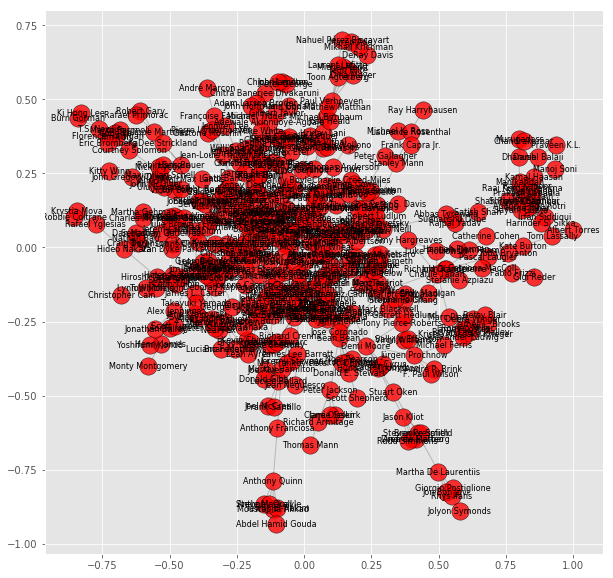

In [276]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')

#cc = nx.betweenness_centrality(G2)
nodes = nx.draw_networkx_nodes(G_clean, pos,
                               cmap=plt.cm.Set1,
                               #node_color=ccp['value'],
                               #node_size=[((v*10000)) for v in cc.values()],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G_clean, pos, font_size=8)

nx.draw_networkx_edges(G_clean, pos, width=1.0, alpha=0.2)

# Run centrality measures on this new subgraph.

In [277]:
dc1000 = nx.degree_centrality(G_clean)
dc1000 = pd.DataFrame([dc1000.keys(), dc1000.values()]).T
dc1000.columns= ['names', 'values']
dc1000 = dc1000.sort_values(by='values', ascending=False)
dc1000 = pd.merge(dc1000,partition1, how='left', left_on="names",right_on="index")

In [302]:
ec1000 = nx.eigenvector_centrality(G_clean,weight='freq',max_iter=1000)
ec1000 = pd.DataFrame([ec1000.keys(), ec1000.values()]).T
ec1000.columns= ['names', 'values']
ec1000 = ec1000.sort_values(by='values', ascending=False)
ec1000 = pd.merge(ec1000,partition1, how='left', left_on="names",right_on="index")

In [279]:
bc1000 = nx.betweenness_centrality(G_clean,weight='freq')
bc1000 = pd.DataFrame([bc1000.keys(), bc1000.values()]).T
bc1000.columns= ['names', 'values']
bc1000 = bc1000.sort_values(by='values', ascending=False)
bc1000 = pd.merge(bc1000,partition1, how='left', left_on="names",right_on="index")

In [280]:
cc1000 = nx.closeness_centrality(G_clean,distance='freq')
cc1000 = pd.DataFrame([cc1000.keys(), cc1000.values()]).T
cc1000.columns= ['names', 'values']
cc1000 = cc1000.sort_values(by='values', ascending=False)
cc1000 = pd.merge(cc1000,partition1, how='left', left_on="names",right_on="index")

Combine all centrality measures into one node file and one link file for Gephi visualizations.

In [284]:
dc1000 = dc1000[['names','values','value']]
dc1000.columns = ['names','dc','group']
ec1000 = ec1000[['names','values']]
ec1000.columns = ['names','ec']
bc1000 = bc1000[['names','values']]
bc1000.columns = ['names','bc']
cc1000 = cc1000[['names','values']]
cc1000.columns = ['names','cc']

In [285]:
nodes1000 = pd.merge(dc1000,ec1000, how='left', left_on="names",right_on="names")
nodes1000 = pd.merge(nodes1000,bc1000, how='left', left_on="names",right_on="names")
nodes1000 = pd.merge(nodes1000,cc1000, how='left', left_on="names",right_on="names")

In [286]:
nodes1000 = nodes1000[['names','group','dc','ec','bc','cc']]

Gephi is particular that the node id column be called "Id"

In [290]:
nodes1000 = nodes1000.rename(columns={'names': 'Id'})

Output these data into csv files for Gephi

In [293]:
nodes1000.to_csv("nodesForGephi1000.csv")
net1000.to_csv("linksForGephi1000.csv")

Create the nodes and links files for creating the Gephi visual and the d3 visual. 

In [406]:
nodes,net = createTopNodesforVisual(bc10_2,"total",12,0.001,4)

In [407]:
nodes['id'].count()

90

In [408]:
nodes['value'].nunique()

13

In [409]:
#exportData(nodes,net,"bc")

Save these as csv files for the Gephi visual.

In [410]:
nodes.to_csv("nodesVisual.csv")
net.to_csv("netVisual.csv")

In [388]:
def createTopNodesforVisual(df,nameOfFile,head,threshold,minDegree):
    #Only use groups with more than 900 members
    top = df.groupby('value')['names'].filter(lambda x: len(x) > 900)
    df = df.loc[df['names'].isin(top)]
    #df = df.loc[~((df['value'] == 0) | (df['value'] == 15))] #Just manually remove these tiny group
    degreeNetwork = filterByPartitionAndCentrality(df,head,threshold)
    degreeNetwork = degreeNetwork.sort_values(by="values",ascending=False).head(1000)
    singles = degreeNetwork.groupby('value')['names'].filter(lambda x: len(x) < 4)
    degreeNetwork = degreeNetwork.loc[~degreeNetwork['names'].isin(singles)]
    degreeNetwork = buildNetworkFromData(df1,degreeNetwork,minDegree)
    nodes = buildNodesFromLinks(degreeNetwork,df)
    exportData(nodes,degreeNetwork,nameOfFile)
    return(nodes,degreeNetwork)

In [312]:
#This returns the network of a given actor. 
def getNetwork(name,network):
    node = network.loc[network['nconst'] == name]
    nodeNetwork = pd.merge(node,network, how='left', left_on="tconst",right_on="tconst")
    node = pd.DataFrame(nodeNetwork['nconst_y'])
    node['freq'] = node.groupby('nconst_y')['nconst_y'].transform('count')
    node['Name'] = name
    node = node.drop_duplicates()
    node = node.drop(node[node['nconst_y'] == name].index)
    node = pd.DataFrame(np.sort(node[['nconst_y','Name']],1)).drop_duplicates()
    node = node.drop_duplicates()
    node.columns = ['nconst_y','Name']
    return(node)

In [313]:
def buildNetworkFromData(network,df,minDegree):
    df = network.loc[(network['source'].isin(df['names'])) & (network['target'].isin(df['names']))]
    G_clean = nx.from_pandas_edgelist(df, 'source', 'target',edge_attr='freq')
    remove = [node for node,degree in dict(G_clean.degree()).items() if degree < minDegree]
    G_clean.remove_nodes_from(remove)
    G_clean = nx.to_pandas_edgelist(G_clean)
    #G_clean = pd.merge(G_clean,names,how='left',left_on='source',right_on='nconst')
    #G_clean = pd.merge(G_clean,names,how='left',left_on='target',right_on='nconst')
    G_clean = pd.DataFrame(G_clean[['source','target','freq']])
    #G_clean.columns = ['source','target']
    #G_clean = G_clean.dropna()
    #G_clean = G_clean.drop_duplicates()
    return G_clean

In [314]:
def filterByPartitionAndCentrality(df,head,centralityThreshold):
    df = df.groupby('value').head(head)
    #df = df.head(head)
    df = df.loc[df['values'] > centralityThreshold]
    return df

In [315]:
def buildNodesFromLinks(df,centralityData):
    nodes1 = pd.DataFrame(df['source'])
    nodes2 = pd.DataFrame(df['target'])
    nodes2.columns = ['source']
    nodes = pd.concat([nodes1,nodes2])
    nodes = nodes.drop_duplicates()
    nodes2 = pd.merge(nodes,centralityData,how='left',left_on='source',right_on='names')
    nodes2 = nodes2.dropna()
    nodes2 = pd.DataFrame(nodes2[['names','values','value']])
    nodes2.columns = ['id','cent','value']
    return nodes2

In [316]:
def exportData(nodes,network,fileName):
    d1 = nodes.to_dict(orient='records')
    j1 = json.dumps(d1)
    d2 = network.to_dict(orient='records')
    j2 = json.dumps(d2)
    d1 = {"nodes":d1, "links":d2}
    with open(fileName + ".json", 'w', encoding='utf-8') as f:
        json.dump(d1, f, ensure_ascii=False,indent=4)